In [1]:
!apt-get -y install google-chrome-stable

Reading package lists... Done
Building dependency tree       
Reading state information... Done
google-chrome-stable is already the newest version (98.0.4758.102-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [2]:
chrome_driver_version = !curl -get http://chromedriver.storage.googleapis.com/LATEST_RELEASE
chrome_driver_version = chrome_driver_version[-1]
url = f'http://chromedriver.storage.googleapis.com/{chrome_driver_version}/chromedriver_linux64.zip'
url

'http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip'

In [3]:
!wget -O /tmp/chromedriver.zip $url

--2022-02-28 06:50:12--  http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 34.64.4.112, 2404:f340:10:1803::2010
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|34.64.4.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10229802 (9.8M) [application/zip]
Saving to: ‘/tmp/chromedriver.zip’

/tmp/chromedriver.z 100%[===================>]   9.76M  15.9MB/s    in 0.6s    

2022-02-28 06:50:13 (15.9 MB/s) - ‘/tmp/chromedriver.zip’ saved [10229802/10229802]



In [4]:
!unzip -o /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

Archive:  /tmp/chromedriver.zip
  inflating: /usr/local/bin/chromedriver  


In [5]:
import pandas as pd 
import os
from hanspell import spell_checker
import requests
from urllib import parse
import json
from multiprocessing.dummy import Process, Queue, Pool, Manager
import math
import re
from time import process_time, sleep
from ckonlpy.tag import Twitter
from nltk import ngrams
from os import getpid
from selenium import webdriver
from IPython import display
from base64 import b64decode
from google.cloud import vision
import io
from PIL import Image
import csv
import uuid
import time

In [6]:
schoolNoticeListPath = './train_data'
schoolNoticeListPath = os.path.join(schoolNoticeListPath, 'school-notice.csv')
schoolNoticeListPath

'./train_data/school-notice.csv'

In [7]:
schoolNoticeList = pd.read_csv(schoolNoticeListPath)
schoolNoticeList.head()

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25


In [8]:
schoolNoticeList.dtypes

idx          int64
url         object
category    object
date        object
dtype: object

In [9]:
schoolNoticeList.size

21192

In [10]:
options = webdriver.chrome.options.Options()
options.add_argument("--no-sandbox")
options.add_argument("--disable-setuid-sandbox")
options.add_argument("--disable-extensions")
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")
driver = webdriver.Chrome(chrome_options=options)

driver.get("https://httpstat.us/200")

if "200 OK" in driver.page_source:
    print('Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you\'re all set!')
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you're all set!


In [11]:
url = schoolNoticeList['url'][0]
url

'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=False&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca'

In [12]:
driver.get(url)

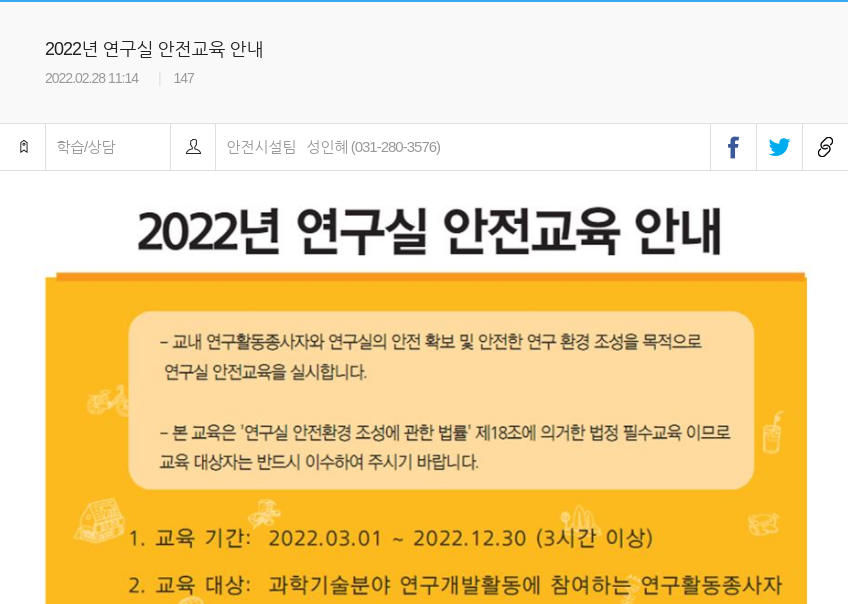

In [13]:
assert driver.page_source is not None
content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
display.Image(b64decode(content.screenshot_as_base64))

In [14]:
body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
body.get_attribute('innerHTML')#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02 > 

'<li class="first last odd li_index0 li_respon w100"><div class="inner_txt"><div class="tbl_view cke_editable cke_editable_themed cke_contents_ltr"><p class="contents_add_one1" style="display:none;">연구실 안전교육</p><p class="contents_add_one2" style="display:none;">안전시설팀</p><p><img alt="" src="/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180"></p><p>&nbsp;</p></div></div></li>'

In [15]:
body.text.strip()

''

In [16]:
'img' in body.get_attribute('innerHTML')

True

In [17]:
img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
img_list

['https://web.kangnam.ac.kr/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180']

In [18]:
'base64' in img_list[0]

False

In [19]:
schoolNoticeSrcListPath = os.path.join('./train_data/src', f'{uuid.uuid1()}.png')
os.makedirs('./train_data/src', exist_ok=True)
img_data = requests.get(img_list[0]).content
with open(schoolNoticeSrcListPath, 'wb') as handler:
    handler.write(img_data)

In [20]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·\s]', '', inputString)
    return text_rmv

In [21]:
def export_notice_text(body):
    return clean_text(body.text.strip())

In [22]:
def export_title_text(body):
    return clean_text(body.find_element_by_css_selector('div.tblw_subj.nanum').text.strip())

In [23]:
train_data_src = './train_data/src'
os.makedirs(train_data_src, exist_ok=True)

def export_notice_img_list(body):
    img_saved_path_list = []
    if 'img' in body.get_attribute('innerHTML'):
        img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
#         print('img_list', img_list)
        for img_src in img_list:
            srcPath = os.path.join(train_data_src, f'{uuid.uuid1()}.png')
#             print(srcPath, img_saved_path_list)
            if 'base64' in img_src:
#                 print('append?', img_saved_path_list.append(srcPath), img_saved_path_list)
                with open(srcPath, "wb") as f:
                    f.write(b64decode(re.search(r'base64,(.*)', img_src).group(1)))
                img_saved_path_list.append(srcPath)
#                 print(srcPath, img_saved_path_list)
            else:
                img_data = requests.get(img_src).content
                with open(srcPath, 'wb') as handler:
                    handler.write(img_data)
                img_saved_path_list.append(srcPath)
#                 print(srcPath, img_saved_path_list)
    return img_saved_path_list

In [24]:
def export_notice_data(driver, url, idx = None):
    if driver is None or url is None:
        print(f'idx: {idx}, driver or url is None')
        return (idx, None, None, None)
    driver.get(url)
    
    if driver.page_source is None:
        print(f'idx: {idx}, page_source is None')
        return (idx, None, None, None)
    
    content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
    
    body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
#     print(content.text, 'body', body.text)
    return (idx, export_title_text(content), export_notice_text(body), export_notice_img_list(body))

In [25]:
assert len(export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=1db853c16158bdae31c09d146d4571dc')[3]) == 4
assert len (export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca')[3]) == 1

In [26]:
result = export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=a9e53dcab66d25012cdc87c13d1c9c1d')

assert (None, len(result[1]), len(result[2]), len(result[3])) == (None, 26, 845, 0)

In [27]:
schoolNoticeList[:10]

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
5,5293,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
6,5292,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
7,5291,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
8,5290,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
9,5289,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.23


In [28]:
t1_start = time.perf_counter()
for idx in range(10):
    export_notice_data(driver, schoolNoticeList['url'][idx], idx)
t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'time: {takeTime:>8}s')

time:     6.84s


In [62]:
reqNum = 5
driver_pool = []

for idx in range(reqNum):
    options = webdriver.chrome.options.Options()
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-setuid-sandbox")
    options.add_argument("--disable-extensions")
    options.add_argument('headless')
    options.add_argument('window-size=1920x1080')
    options.add_argument("disable-gpu")
    driver = webdriver.Chrome(chrome_options=options)
    driver_pool.append(driver)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [63]:
processQueue = Queue()
while not processQueue.empty():
    try:
        processQueue.get(False)
    except Empty:
        continue
#     processQueue.task_done()
processQueue.qsize()

0

In [64]:
lastProcessPercentage = 0
dataSize = 20#len(schoolNoticeList['idx'])
t1_start = time.perf_counter()
debug = True
offset = 0
TIMEOUT = 5

for pid in range(math.ceil(dataSize / reqNum)):
    start = pid * reqNum + 1 + offset
    
    if (start / dataSize) * 100 - lastProcessPercentage > 5:
        lastProcessPercentage = round((start / dataSize) * 100, 2)
        t1_stop = time.perf_counter()
        takeTime = round(t1_stop - t1_start, 2)
        print(f'process...{lastProcessPercentage:>6}% time: {takeTime:>8}s')
    
    if start + reqNum > dataSize:
        end = dataSize + 1
    else:
        end = start + reqNum
    processList = []
    print(f'{start:>5} ~ {end:>5} start!') if debug else None
    with Pool(processes=reqNum) as pool:
#         print('pool start')
        results = [pool.apply_async(export_notice_data, (driver_pool[idx % reqNum], schoolNoticeList['url'][idx], idx)) for idx in range(start, end)]
#         print('result ')
        sleep(TIMEOUT)
        pool.terminate()
#         print('terminate', len(results))
        for idx in range(len(results)):
#             print(results[idx].get())
            processQueue.put(results[idx].get())
#         [print(res.get()) for res in results]#processQueue.put
#         print('send queue')
#         print(results[0].get())
    print(f'{start:>5} ~ {end:>5} done! queue size: {processQueue.qsize()}') if debug else None

t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'process...100% time: {takeTime:>8}s')

    1 ~     6 start!
    1 ~     6 done! queue size: 5
process...  30.0% time:     5.04s
    6 ~    11 start!
    6 ~    11 done! queue size: 10
process...  55.0% time:    10.09s
   11 ~    16 start!
   11 ~    16 done! queue size: 15
process...  80.0% time:    15.15s
   16 ~    21 start!
   16 ~    21 done! queue size: 20
process...100% time:    20.21s


In [65]:
driver_pool
for driver in driver_pool:
    driver.close()

In [66]:
while not processQueue.empty():
    data = processQueue.get(0)
    print(data)

(1, '교목실20221학기온라인학생채플일정', '', ['./train_data/src/85bec290-9864-11ec-b5fd-0242ac120002.png'])
(2, '20221학기학부및대학원재학생추가1차등록기간안내', '20221학기학부대학원재학생추가1차등록기간안내1등록기간가재학생학부대학원일시납추가1차20220302수0304금가상계좌송금매일17시마감나재학생학부대학원분납1차20220302수0304금가상계좌송금매일17시마감다학부9학기초과학점등록생20220314월0317목가상계좌송금매일17시마감2등록방법종합정보로그인→등록관리→등록금고지서출력→은행창구직접납부또는고지서상의가상계좌로송금3납부은행KB국민은행전국지점4등록금납부확인종합정보시스템로그인→기본정보조회→등록조회화면에서확인등록금을납부한다음날부터확인가능5등록금납입영수증이필요한경우가종합정보로그인→등록관리→교육비납입증명서→교육비납입확인서출력나학교홈페이지→자주찾는서비스→인터넷증명발급다교학팀에서교육비납입확인서를신청교학1팀샬롬관1층☏0312803412교학2팀경천관1층☏03128034424대학원교학팀샬롬관10층☏031280347134762022년연말정산용교육비납입증명서는2023년1월부터가능6기타사항가전액학비감면을받는경우실납부금0원에도꼭등록기간에납부절차를완료하여야합니다<실납부금액0원등록방법>1고지서를지참하여KB국민은행에방문하여창구또는ATM기로등록금납부처리2KB국민은행인터넷뱅킹로그인–공과금납부–대학등록금납부–학교학번가상계좌번호입력0원납부처리나등록금고지서에있는가상계좌는개인별로부여된계좌번호이므로예금주는학생본인입니다따라서입금자의명의와상관없이등록금을가상계좌에입금하면등록처리됩니다다등록금납부장학금및학자금대출관련문의처①등록금납부방법문의회계경리팀0312803563②학부장학금및학자금대출관련문의장학복지팀03128035512③대학원장학금및학자금대출관련문의대학원교학팀0312803476정부지원학자금대출안내신청방법한국장학재단wwwkosafgokr에서온라인신청문의전화15992000한국장학재단콜센터총무처장', [])
(3, '교외_신청2022년1학기「